In [ ]:
%pip install summarytools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import gspread
import matplotlib.pyplot as plt
from google.colab import auth
from google.auth import default
from summarytools import dfSummary
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

###1. load data from Google Sheets, if it fails, read from CSV in GitHub

In [ ]:
url = "https://docs.google.com/spreadsheets/d/15K7rSrYQDJOtpiyxfCU1NKqeyeQERtqb07kzZnwrzaE/edit?gid=1663028978"
github_csv = "https://raw.githubusercontent.com/Juanmeve837/ETL_appsheet_googlesheet_colab/0c14f16eccce2fe9b9aa95d79b3f70314c2847c7/Data/Equip_perf_data.csv"

In [ ]:
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    gsheets = gc.open_by_url(url)
    sheets = gsheets.worksheet("Timesheet").get_all_values()

    df = pd.DataFrame(sheets[1:], columns=sheets[0])
    print("Data successfully loaded from Google Sheets")

except Exception as e:
    print("Failed to load data from Google Sheets, falling back to GitHub CSV...")
    print("Error:", e)
    df = pd.read_csv(github_csv, index_col=0)
    print("Data successfully loaded from GitHub CSV")



Data successfully loaded from Google Sheets


In [ ]:
df.head(5)

,Log ID,Shovel,Date/Time In,Date/Time Out,Total_Hours,Material_Type,Ripper,Operator,Supervisor,Haul_Truck,Volume,Status
0,357ea181,KOM 390-9,2024-02-25 07:52:18,2024-02-25 07:56:01,0 days 00:03:43,Hard,False,Duvan Moreno,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded
1,3ee6e9b3,KOM 390-4,2024-02-25 07:52:52,2024-02-25 07:57:52,0 days 00:05:00,Hard,False,Aristobulo Gualdron,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded
2,8fee0445,KOM 390-9,2024-02-25 07:56:03,2024-02-25 08:01:52,0 days 00:05:49,Hard,False,Duvan Moreno,Supervisor1@gmail.com,Haul_truck_27m3,Normal,Loaded
3,41de77da,KOM 390-4,2024-02-25 07:58:08,2024-02-25 08:02:04,0 days 00:03:56,Hard,False,Aristobulo Gualdron,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded
4,a3ea0bc0,KOM 390-4,2024-02-25 08:02:05,2024-02-25 08:05:17,0 days 00:03:12,Hard,False,Duvan Moreno,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded


###2. Transform data

In [ ]:
df["Date/Time In"] = pd.to_datetime(df["Date/Time In"],dayfirst=True)
df["Date/Time Out"] = pd.to_datetime(df["Date/Time Out"],dayfirst=True)
df["Total_Hours"] = pd.to_timedelta(df["Total_Hours"])

In [ ]:
df.head(5)

,Log ID,Shovel,Date/Time In,Date/Time Out,Total_Hours,Material_Type,Ripper,Operator,Supervisor,Haul_Truck,Volume,Status
0,357ea181,KOM 390-9,2024-02-25 07:52:18,2024-02-25 07:56:01,0 days 00:03:43,Hard,FALSE,Duvan Moreno,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded
1,3ee6e9b3,KOM 390-4,2024-02-25 07:52:52,2024-02-25 07:57:52,0 days 00:05:00,Hard,FALSE,Aristobulo Gualdron,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded
2,8fee0445,KOM 390-9,2024-02-25 07:56:03,2024-02-25 08:01:52,0 days 00:05:49,Hard,FALSE,Duvan Moreno,Supervisor1@gmail.com,Haul_truck_27m3,Normal,Loaded
3,41de77da,KOM 390-4,2024-02-25 07:58:08,2024-02-25 08:02:04,0 days 00:03:56,Hard,FALSE,Aristobulo Gualdron,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded
4,a3ea0bc0,KOM 390-4,2024-02-25 08:02:05,2024-02-25 08:05:17,0 days 00:03:12,Hard,FALSE,Duvan Moreno,Supervisor1@gmail.com,Haul_truck_15m3,Normal,Loaded


###3. Fix NaN and Outliers

In [ ]:
df1 = df.copy()
df1 = df1.dropna(subset=['Date/Time Out'])
df1["Total_Hours_min"] = pd.to_timedelta(df1["Total_Hours"]).dt.total_seconds() / 60  # in minutes

In [ ]:
dfSummary(df1)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Log ID[object],1. f01a134f2. 9bf0ae9a3. 63764b1d4. f93f460a5. aa430e7d6. 534dfdaa7. 64387ecc8. 5c12670b9. d12fe6ae10. 85cb094b11. other,"15 (0.6%)15 (0.6%)9 (0.4%)9 (0.4%)9 (0.4%)9 (0.4%)9 (0.4%)9 (0.4%)9 (0.4%)9 (0.4%)2,423 (96.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA31JREFUeJzt3DFqG1EARdEvI0zcjBACLUaL8GKzCO1GCE0RGzdKEacIUQIB+w4o51Qh1RSX0eTzX1bX63VA4WHpB+D/ITYyYiMjNjJiIyM2MmIjIzYyYiOzGmM8jTHG9Xp9WfhZuHPr3W73PMYYq9Xqq+D4TA/TNG2nadqOMR6Xfhjum282MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOznuf5/P7nt0WfhLtng0Bm5b/MouLNRsa6iox1FRlHH2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyLgWTsbghYw3GxmDFzIGL2QcfZARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IeNaOBmDFzK+2cj4GSVjXUXGuoqMbzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWRcCydjXUXGm42MwQsZgxcyjj7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLZyMwQsZbzYyBi9kDF7IOPogIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWRsEMhYV5HxZiNjXUXGuoqMow8yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2RcCydj8ELGm42MwQsZgxcyjj7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLZyMwQsZ32xk/IySsa4iY11FxjcbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoyroWTsa4i481GxuCFjMELGUcfZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IuBZOxuCFzM83myvhfKS3W7+U691u9/y+QYAPMc/z+daAaj1N0/ZwOLxsNpvXpR6O+3G5XL4cj8ft6XR6HGP8GtsYY2w2m9f9fv9tkafjHj3d+kvnbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTWY/y4FrL0g3Af/tbSep7n8/F43I4/XAuBf/U+ovptQOVaOJ/h5rVwgxcy/oFARmxkxEZGbGTERkZsZMRGRmxkxEbmOwi5ECd/eNoBAAAAAElFTkSuQmCC"">",0(0.0%)
2,Shovel[object],1. CAT 349-62. KOM 390-43. KOM 390-94. CAT 336-35. KOM 390-106. CAT 320-17. CAT 336-88. CAT 320-29. KOM 360-1410. KOM 360-13,721 (28.6%)506 (20.0%)498 (19.7%)371 (14.7%)156 (6.2%)113 (4.5%)75 (3.0%)32 (1.3%)28 (1.1%)25 (1.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADnCAYAAAAJgSQ2AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA9lJREFUeJzt3UFOG1kARdFvhNLNxBZCYhksgEX0YnsRXgD7QIgahCQT96AjhBIIJrhuificFfzB1beqVA9Wu91uQOFk6QNwPMRGRmxkxEZGbGTERkZsZMRGRmxkVmOMszHGp6UP8gbfdrvdw9KH4O1OLy4u/lmv1+dLH2Rf0zTdrVarfwX38Zyu1+vz6+vrh81m82Xpw7zm/v7+7+12e357e/tpjCG2D+Z0jDE2m82Xy8vLz0sfZk9nSx+A3+MBgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczpGP9/urP0QfbxUc7J806nabrbbrfn44N8ujNN090Y49vS5+DtfBZOZuWvGFFZ+mZzSx2RRQcvxivHZbHBi/HK8Vl68PIhnoA5DC91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyCw2eDFeOT6LDl6MV46Lz8LJGLyQcbORMXghY/BCxuCFjJe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjHUVGRsEMtZVZOa+2dxcPJp1XWU9xVOzrausp/jR3Osq6ykeealLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGZrbBi0ELP5p18GLQwlM+Cydj8ELmLTebW4p32XvwYrzCe+01eDFe4RDeMngxXuFdvNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjs9fgxXiFQ9h78GK8wnv5LJyMwQsZDwhkXvsZ9dPJwfxyXWVRxSG9uK6yqOLQXltXWVRxMB4QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyLy4rrKo4tB+ua6yqOKQfBZOxrqKzEs3mxuNg3t28GLowhx+GrwYujCXlwYvhi4cnJe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZH4avBi6MJdnBy+GLszBZ+FkDF7IeEAg8/Rn1E8ns3pcV1lUMbeT9Xp9fnV1Nb7P+fb5v6PwW07GGOPs7Ozr0gfhz+cBgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczJGGM8PDz8tfRB+POdTNN0d3NzY1HF7HwWTsa6ioybjYzBCxmDFzIGL2S81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMz8LJGLyQcbORMXghY/BCxuCFjJe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjHUVGRsEMtZVZDwgkBEbGbGRERsZsZERGxmxkfkPKqrsE8VMmA0AAAAASUVORK5CYII="">",0(0.0%)
3,Date/Time In[datetime64[ns]],Min: 2024-02-25Max: 2025-08-18Duration: 540 days,2469 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAARxJREFUeJzt3NEJgzAAQEFbul5nEmfqgHaB4kegrzXe/QoSyCNCErzt+75A4f7rAXAdYiMjNjKPo4fbtj1HXrqu62tsOMzMykZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGR

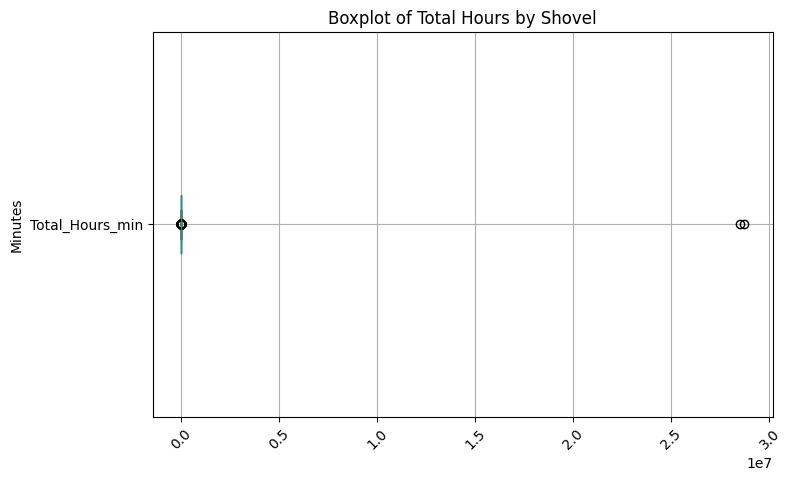

In [ ]:
# Boxplot "Total_Hours"
plt.figure(figsize=(8,5))
df1.boxplot(column="Total_Hours_min", vert=False)
plt.title("Boxplot of Total Hours by Shovel")
plt.suptitle("")
plt.ylabel("Minutes")
plt.xticks(rotation=45)
plt.show()


In [ ]:
for key, group_df in df1.groupby(["Haul_Truck","Shovel"]):
  Q1 = group_df['Total_Hours'].quantile(0.25)
  Q3 = group_df['Total_Hours'].quantile(0.75)
  IQR = Q3 - Q1

  limite_inferior = Q1 - 2 * IQR
  limite_superior = Q3 + 2 * IQR

  mean =  group_df['Total_Hours'].mean()

  # Select rows that meet the IQR outlier condition
  outliers = group_df[(group_df['Total_Hours'] < limite_inferior) | (group_df['Total_Hours'] > limite_superior)]

  # Replace outlier values with the corresponding mean
  df1.loc[outliers.index, 'Total_Hours'] = np.nan

In [ ]:
# Calculate the mean of "Total_Hours" for each group ("Haul_Truck", "Shovel")
group_means = df1.groupby(["Haul_Truck", "Shovel"])["Total_Hours"].transform("mean")

# Fill NaN values in "Total_Hours" with the corresponding group mean
df1["Total_Hours"] = df1["Total_Hours"].fillna(group_means)

# Fill missing values in "Date/Time In" using "Date/Time Out" minus "Total Hours"
df1["Date/Time In"] = df1["Date/Time In"].fillna(df1["Date/Time Out"] - df1["Total_Hours"])

In [ ]:
df1["Total_Hours_min"] = pd.to_timedelta(df1["Total_Hours"]).dt.total_seconds() / 60  # in minutes

<Figure size 800x500 with 0 Axes>

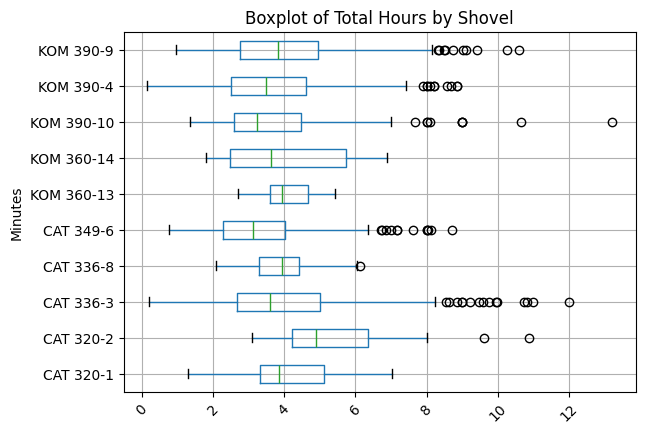

<Figure size 800x500 with 0 Axes>

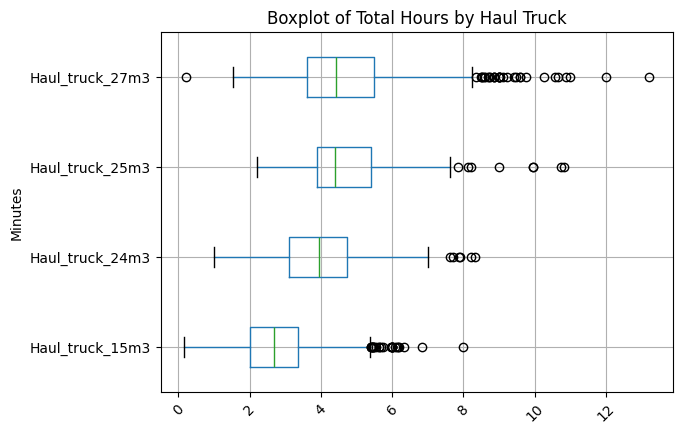

In [ ]:
# Boxplot grouped by Shovel
plt.figure(figsize=(8,5))
df1.boxplot(column="Total_Hours_min", by="Shovel", vert=False)
plt.title("Boxplot of Total Hours by Shovel")
plt.suptitle("")
plt.ylabel("Minutes")
plt.xticks(rotation=45)
plt.show()

# Boxplot grouped by Haul_Truck
plt.figure(figsize=(8,5))
df1.boxplot(column="Total_Hours_min", by="Haul_Truck", vert=False)
plt.title("Boxplot of Total Hours by Haul Truck")
plt.suptitle("")
plt.ylabel("Minutes")
plt.xticks(rotation=45)
plt.show()

###4. Determine observation group and generate a unique code by group and shovel

In [ ]:
def assign_group(group_df):
    group_df_sorted = group_df.sort_values("Date/Time In").copy()
    group_df_sorted["time_diff"] = group_df_sorted["Date/Time In"].diff()
    group_df_sorted["Group"] = (group_df_sorted["time_diff"] > pd.Timedelta(hours=2)).cumsum() + 1 # Start new group if time gap > 2 hours
    return group_df_sorted[["Group"]]

# Apply by shovel
groups = df1.groupby("Shovel", group_keys=False).apply(assign_group, include_groups=False)

# Merge back into df1
df1 = df1.join(groups)

# Create Cod
df1["Cod"] = df1["Group"].astype(str) + df1["Shovel"].str[:3] + df1["Shovel"].str[-1]

### 5. calculate performance in cubic meters per hour


In [ ]:
vol = {
    'Haul_truck_24m3': 24,
    'Haul_truck_27m3':27,
    'Haul_truck_25m3':25,
    'Haul_truck_15m3':15}

In [ ]:
df1["Vol_m3"] = df["Haul_Truck"].map(vol)

In [ ]:
agreg = {
    'Sumvol': ('Vol_m3', 'sum'),
    'Start': ('Date/Time In', 'min'),
    'End': ('Date/Time Out', 'max')
}

Result = df1.groupby(["Shovel",'Cod']).agg(**agreg)

# Calculate the duration as the difference between 'End' and 'Start
Result['Time_span'] = Result['End'] - Result['Start']

In [ ]:
Result["Performance"] = (Result["Sumvol"]*pd.Timedelta(hours=1))/Result["Time_span"]

<Figure size 800x500 with 0 Axes>

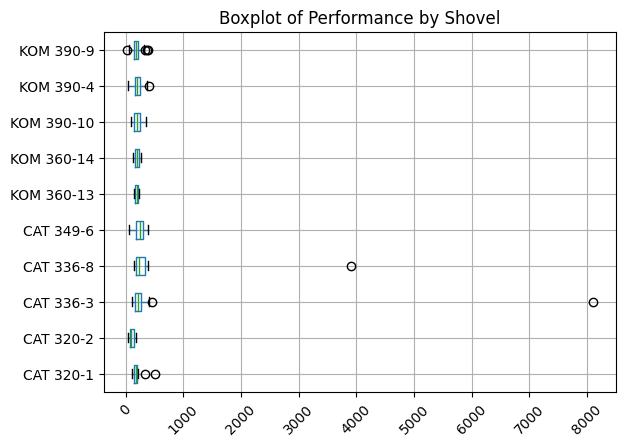

In [ ]:
# Boxplot grouped by Haul_Truck
plt.figure(figsize=(8,5))
Result.boxplot(column="Performance", by="Shovel", vert=False)
plt.title("Boxplot of Performance by Shovel")
plt.suptitle("")
plt.ylabel("")
plt.xticks(rotation=45)
plt.show()

In [ ]:
Result = Result[Result['Performance']<1000] # fix outliers

<Figure size 800x500 with 0 Axes>

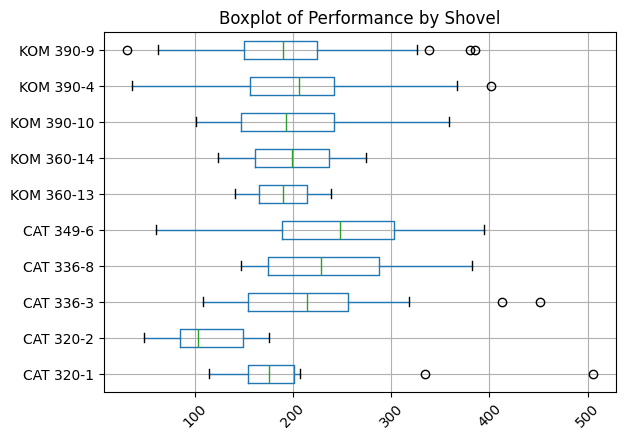

In [ ]:
# Boxplot performance grouped by Shovel
plt.figure(figsize=(8,5))
Result.boxplot(column="Performance", by="Shovel", vert=False)
plt.title("Boxplot of Performance by Shovel")
plt.suptitle("")
plt.ylabel("")
plt.xticks(rotation=45)
plt.show()

In [ ]:
Result.loc[:, "Date"] = Result["Start"].dt.date

In [ ]:
Result["Shovel_Type"]= Result.index.get_level_values("Shovel").str[:7]

<Figure size 800x500 with 0 Axes>

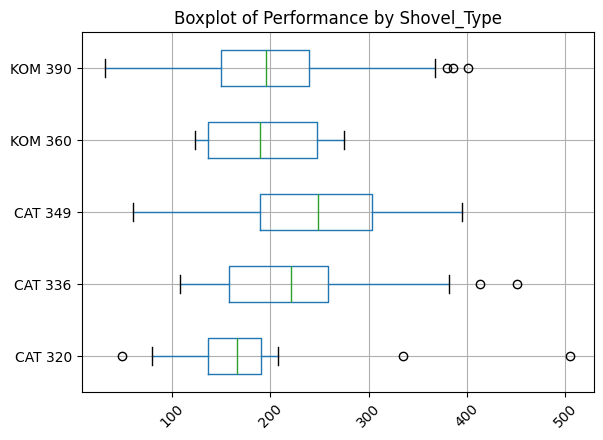

In [ ]:
# Boxplot performance grouped by Shovel_Type
plt.figure(figsize=(8,5))
Result.boxplot(column="Performance", by="Shovel_Type", vert=False)
plt.title("Boxplot of Performance by Shovel_Type")
plt.suptitle("")
plt.ylabel("")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Histogram of Performance separated by Shovel_Type
fig = px.histogram(
    Result,
    x="Performance",
    facet_col="Shovel_Type",   # One plot per Shovel_Type
    facet_col_wrap=3,          # Number of plots per row
    nbins=20,                  # Number of bins
    opacity=0.7,
    color="Shovel_Type",       # Keeps colors consistent
    title="Performance Distribution by Shovel Type"
)

# Update axis labels
fig.update_layout(
    xaxis_title="Performance",
    yaxis_title="Count"
)

fig.show()

### 6. Tracking observations by supervisor"

In [ ]:
counts = df1.groupby("Supervisor").size().reset_index(name="Count")

fig = px.bar(
    counts,
    x="Count",
    y="Supervisor",
    orientation="h",
    text="Count",
    color="Supervisor" # Show values at the end of each bar
    )

fig.update_traces(textposition="outside")
fig.update_layout(
    title="Records by Supervisor",
    xaxis_title="Count",
    yaxis_title="Supervisor",
    showlegend=False
)

fig.show()